In [14]:
import random
import os
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from dataset.data_loader import GetLoader
from torchvision import datasets
from torchvision import transforms
from models.model import CNNModel
import numpy as np
from models.test import test
import matplotlib.pyplot as plt


In [2]:
!pip install visdom

In [3]:
'''
Configuration block

Question
    what is manual seed?
        Answer : https://discuss.pytorch.org/t/what-is-manual-seed/5939
        Answer2 : https://pytorch.org/docs/master/torch.html?highlight=manual_seed#torch.manual_seed
        manual seed is pytorch random number generators

'''

source_data_name = 'MNIST'
target_data_name = 'mnist_m'
source_image_root = os.path.join('dataset',source_data_name)
target_image_root = os.path.join('dataset',target_data_name)
model_root = 'models'
cuda = True
cudnn.benchmark = True

lr = 1e-3
batch_size = 128
image_size = 28
n_epoch = 100

manual_seed = random.randint(1,10000)
random.seed(manual_seed)
torch.manual_seed(manual_seed)

print('source image root : ',source_image_root)
print('target image root : ',target_image_root)

source image root :  dataset/MNIST
target image root :  dataset/mnist_m


In [4]:
'''
Data configuration block

torch vision trasnform documentation
    documentation : https://pytorch.org/docs/stable/torchvision/transforms.html
    Transforms are common image transformations. 
    'Compose'를 이용, 한번에 image chanege
    
    Transform Questions
    1. normalize source mean, std values
        Answer : https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457
        
    2. normalize target mean, std values
'''

img_transform_source = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean= (0.1307,), std=(0.3081,))
])

img_transform_target = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))  
])

In [5]:
'''
Data load block
    Questions
    1. what is DataLoader's num_worker, it is look like number of GPU
        Answer (Guideline) : https://discuss.pytorch.org/t/guidelines-for-assigning-num-workers-to-dataloader/813
        Answer2 (in documentation) : how many subprocesses to use for data loading. 
                                    0 means that the data will be loaded in the main process.
                                    process를 얼마나 할당할것인지..?
    2. Tatget data shuffle error
        Answer (Now solved) : https://discuss.pytorch.org/t/dataloader-notimplemented-error/35349/4
        Answer2 (Dataloader tutorial) : https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
        
'''

dataset_source = datasets.MNIST(
    root = 'dataset',
    train = True,
    transform = img_transform_source,
    download=True)

dataloader_source = torch.utils.data.DataLoader(
    dataset = dataset_source,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 4 )



train_list = os.path.join(target_image_root, 'mnist_m_train_labels.txt')

print(train_list)


dataset_target = GetLoader(
        data_root = os.path.join(target_image_root,'mnist_m_train'),
        data_list = train_list,
        transform = img_transform_target
)

dataloader_target = torch.utils.data.DataLoader(
    dataset = dataset_target,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 4)

print('source shape : ', len(dataloader_source))
print('target shape : ', dataloader_target)


dataset/mnist_m/mnist_m_train_labels.txt
source shape :  469
target shape :  <torch.utils.data.dataloader.DataLoader object at 0x7f07a01df8d0>


In [6]:
'''
Load model block
&
Setting optimizer and loss

Question
    1. explane model.parameters() and NLLLoss()
    
    Answer (model.parameters())
        Trainable parameter list
        example) for parameter in my_net.parameters():
                    print(parameter)
        https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325
        
    Answer2 (NLLLoss())
        The negative log likelihood loss
        https://pytorch.org/docs/stable/nn.html
    
    2. model.parameters().requires_grad?
        If I want to freeze model weights
        p.requires_grad = False
        즉, 훈련을 시킬것인지 말 것인지를 결정하는 parameter
        정확하게는 False시 backward를 하지 않는다.
        
        https://discuss.pytorch.org/t/model-train-and-requires-grad/25845 (pytorch forum)
        https://pytorch.org/docs/stable/notes/autograd.html (documentation)

'''

my_net = CNNModel()

optimizer = optim.Adam(my_net.parameters(), lr = lr)
loss_class = torch.nn.NLLLoss()
loss_domain = torch.nn.NLLLoss()

if cuda :
    my_net = my_net.cuda()
    loss_class = loss_class.cuda()
    loss_domain = loss_domain.cuda()
    
for p in my_net.parameters():
    p.requires_grad = True


In [7]:
print(my_net.feature)
print(my_net.class_classifier)
print(my_net.domain_classifier)


Sequential(
  (f_conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (f_bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (f_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (f_relu1): ReLU(inplace)
  (f_conv2): Conv2d(64, 50, kernel_size=(5, 5), stride=(1, 1))
  (f_bn2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (f_drop1): Dropout2d(p=0.5)
  (f_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (f_relu2): ReLU(inplace)
)
Sequential(
  (c_fc1): Linear(in_features=800, out_features=100, bias=True)
  (c_bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c_relu1): ReLU(inplace)
  (c_drop1): Dropout2d(p=0.5)
  (c_fc2): Linear(in_features=100, out_features=100, bias=True)
  (c_bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c_relu2): ReLU(inplace)
  (c_fc3): 

In [8]:
'''
Train block

Questions
    1. I don't know what is 'p' & 'alpha' and how can I calculate it.
    Answer (code 분석)
        p는 alpha에 영향을 미치는 hyperparameter 따라서 alpha를 보면 된다.
        alpha는 model에 입력되는 hyperparameter이다.
        alpha -> ReverseLayerF.apply(feature, alpha), model.py -> forward / backward propagation시 영향을 미침
        논문의 \gamma로 추정이 되나, 아직 확실하게 모르겠다.
        paper의 adaptation param을 보자.
    
    2. 학습 순서에 관하여 정리(source / target -> class / domain claasifier)
        순서는 source -> target 순서로 학습이 진행된다.
        Source -> class / domain error
            a. model로 부터 output을 받는다.
            b. 얻은 output을 바탕으로 class / domain loss를 얻는다.
        Target -> class / domain error
            a. model로부터 output을 받는다.
            b. 얻은 output을 바탕으로 class / domain loss 계산
        Source의 loss와 target의 loss를 바탕으로 최종 loss를 계산한다.
         
    3. keras처럼 깔끔히 결과를 json 혹은 다른 형태로 저장 할 수있는 방법? (keras와 호환이 가능하게...?)
        Answer1. (Official documentation)
            torch.save / torch.load를 이용하여 저장 / 불러오기를 한다.
            공식 문서에서는 state_dict을 이용하여 저장하는 것을 권장하고 있다.
            state_dict은 model의 learnable parameter와 registered buffers를 저장해놓은 dictionary이다.
            여튼 tensor의 정보가 들어있는 dictionary 형태.
            print(my_net.state_dict) 를 통하여 어떤 정보가 들어있을 것이란것을 알 수 있다.
            
        Reference : https://pytorch.org/tutorials/beginner/saving_loading_models.html
        
        Answer2. (Bestway to save pytorch model)
            state_dict 형태로 저장하는것이 가장 좋다는 의견이 많다.
            하지만 나는 keras와 혼용이 가능한 형태로 저장하는 방법을 찾아보려고 한다.
            Ref2에 의하면 param / output등이 각각 keras / torch에 최적화 되어있기 때문에 
            torch -> keras는 별로 좋지 않은 생각이라고들 한다. (2017)
            output에서 차이가 존재하는 것 같다.
            별도의 converter로 변환을 시켜줘야 하는 것 같다.
            model param의 경우 단순 수의 나열이므로 호환이 될 것같은데 좀 더 찾아봐야 할 듯...
                  
        Reference : https://stackoverflow.com/questions/42703500/best-way-to-save-a-trained-model-in-pytorch (bestway to save)
        Reference2 : https://discuss.pytorch.org/t/transferring-weights-from-keras-to-pytorch/9889/3 (torch -> keras)
        

    4. err.backward, optimizer.step의 documentation을 보고 pytorch 의 진행을 알아보자
        Answer
            Just compute gradient.
            loss.backward() -> computes dloss/dx (미분값), x.grad 계산
            optimizer.step() -> updates the value of 'x' using the gradient x.grad 우리가 설정한 optimizer에 맞추어
            
            Reference : https://discuss.pytorch.org/t/what-does-the-backward-function-do/9944
            (What does the backward() function do?)
    
    5. 중간중간에 copy는 왜하나...? 데이터가 변환되는 것을 막기위해...?
        Answer
            음... 이 코드에서는 단순 데이터 삽입을 위한 copy로 보인다.
            input_img에서 data container를 생성하고
            s_img를 옮기는 단순 삽입을 위한 copy.
        
'''

# average err
class_s_err = []
source_err = []
target_err = []
final_err = []

source_acc_list = []
target_acc_list = []

for epoch in range(n_epoch):
    
    len_dataloader = min(len(dataloader_source), len(dataloader_target))
    data_source_iter = iter(dataloader_source)
    data_target_iter = iter(dataloader_target)
    
    i =0
    
    temp_class_s_err = []
    temp_source_err = []
    temp_target_err = []
    temp_final_err = []
    temp_s_acc = None
    temp_t_acc = None
    
    while i<len_dataloader:
        
        p = float(i+epoch+len_dataloader) / n_epoch / len_dataloader
        alpha = 2. / (1. + np.exp(-10*p)) -1
        
        ################# source DANN ##################################
        
        data_source = data_source_iter.next()
        s_img, s_label = data_source
        
        my_net.zero_grad()
        batch_size = len(s_label)
        
        input_img = torch.FloatTensor(batch_size, 3, image_size,image_size)
        class_label = torch.LongTensor(batch_size)
        domain_label = torch.zeros(batch_size)
        domain_label = domain_label.long()
            
        if cuda:
            s_img = s_img.cuda()
            s_label = s_label.cuda()
            input_img = input_img.cuda()
            class_label = class_label.cuda()
            domain_label = domain_label.cuda()
        
        input_img.resize_as_(s_img).copy_(s_img)
        class_label.resize_as_(s_label).copy_(s_label)
        
        if (i ==0):
            print(' p value : {} \n alpha : {}'.format(p, alpha))
            print(' size of s_img : {} and s_label : {}: '.format(np.shape(s_img), np.shape(s_label)))
            print(' batch size : ', batch_size)
            print(' input_img shape ',np.shape(input_img))
        
        
        class_output, domain_output = my_net(input_data= input_img, alpha = alpha)
        err_s_label = loss_class(class_output, class_label)
        err_s_domain = loss_domain(domain_output, domain_label)
        
        
        
        ################################################################
        
        ################# Target DANN ##################################
        
        data_target =data_target_iter.next()
        t_img, _ = data_target
        batch_size = len(t_img)
        
        if (i ==0):
            print(' size of t_img : {}'.format(np.shape(t_img)))
            print(' batch size : ', batch_size)
        
        input_img = torch.FloatTensor(batch_size, 3, image_size,image_size)
        domain_label = torch.ones(batch_size)
        domain_label = domain_label.long()
        
        if cuda:
            t_img = t_img.cuda()
            input_img = input_img.cuda()
            domain_label = domain_label.cuda()
        
        input_img.resize_as_(t_img).copy_(t_img)
        
        _, domain_output = my_net(input_data = input_img, alpha = alpha)
        err_t_domain = loss_domain(domain_output, domain_label)
        err = err_t_domain + err_s_domain + err_s_label
        
        temp_class_s_err.append(err_s_label)
        temp_source_err.append(err_s_domain)
        temp_target_err.append(err_t_domain)
        temp_final_err.append(err)
        
        err.backward()
        optimizer.step()
        
        i = i+1
        
        '''
        print ('epoch: %d, [iter: %d / all %d], err_s_label: %f, err_s_domain: %f, err_t_domain: %f' \
              % (epoch, i, len_dataloader, err_s_label.data.cpu().numpy(),
                 err_s_domain.data.cpu().numpy(), err_t_domain.data.cpu().item()))
                 '''
        
    temp_class_s_err = np.asarray(temp_class_s_err,dtype='float32')
    temp_source_err = np.asarray(temp_source_err, dtype = 'float32')
    temp_target_err = np.asarray(temp_target_err, dtype='float32')
    temp_final_err = np.asarray(temp_final_err, dtype= 'float32')
    
    class_s_err.append(np.mean(temp_class_s_err))
    source_err.append(np.mean(temp_source_err))
    target_err.append(np.mean(temp_target_err))
    final_err.append(np.mean(temp_final_err))
    
    temp_s_acc = test(source_data_name, epoch)
    temp_t_acc = test(target_data_name, epoch)
    
    source_acc_list.append(temp_s_acc)
    target_acc_list.append(temp_t_acc)
    
    torch.save(my_net, '{0}/mnist_mnistm_model_epoch_{1}.pth'.format(model_root, epoch))
        
print('Done')

 p value : 0.01 
 alpha : 0.049958374957880025
 size of s_img : torch.Size([128, 1, 28, 28]) and s_label : torch.Size([128]): 
 batch size :  128
 input_img shape  torch.Size([128, 1, 28, 28])
 size of t_img : torch.Size([128, 3, 28, 28])
 batch size :  128
epoch: 0, accuracy of the MNIST dataset: 0.984700
epoch: 0, accuracy of the mnist_m dataset: 0.504611
 p value : 0.010021691973969632 
 alpha : 0.05006656354268846
 size of s_img : torch.Size([128, 1, 28, 28]) and s_label : torch.Size([128]): 
 batch size :  128
 input_img shape  torch.Size([128, 1, 28, 28])
 size of t_img : torch.Size([128, 3, 28, 28])
 batch size :  128
epoch: 1, accuracy of the MNIST dataset: 0.984300
epoch: 1, accuracy of the mnist_m dataset: 0.525164
 p value : 0.010043383947939263 
 alpha : 0.05017475095252921
 size of s_img : torch.Size([128, 1, 28, 28]) and s_label : torch.Size([128]): 
 batch size :  128
 input_img shape  torch.Size([128, 1, 28, 28])
 size of t_img : torch.Size([128, 3, 28, 28])
 batch size

epoch: 21, accuracy of the mnist_m dataset: 0.799245
 p value : 0.010477223427331888 
 alpha : 0.05233824851666102
 size of s_img : torch.Size([128, 1, 28, 28]) and s_label : torch.Size([128]): 
 batch size :  128
 input_img shape  torch.Size([128, 1, 28, 28])
 size of t_img : torch.Size([128, 3, 28, 28])
 batch size :  128
epoch: 22, accuracy of the MNIST dataset: 0.991900
epoch: 22, accuracy of the mnist_m dataset: 0.780802
 p value : 0.010498915401301517 
 alpha : 0.05244641066881006
 size of s_img : torch.Size([128, 1, 28, 28]) and s_label : torch.Size([128]): 
 batch size :  128
 input_img shape  torch.Size([128, 1, 28, 28])
 size of t_img : torch.Size([128, 3, 28, 28])
 batch size :  128
epoch: 23, accuracy of the MNIST dataset: 0.992500
epoch: 23, accuracy of the mnist_m dataset: 0.838685
 p value : 0.010520607375271149 
 alpha : 0.05255457159044208
 size of s_img : torch.Size([128, 1, 28, 28]) and s_label : torch.Size([128]): 
 batch size :  128
 input_img shape  torch.Size([12

epoch: 43, accuracy of the MNIST dataset: 0.991500
epoch: 43, accuracy of the mnist_m dataset: 0.859127
 p value : 0.010954446854663773 
 alpha : 0.05471752772886407
 size of s_img : torch.Size([128, 1, 28, 28]) and s_label : torch.Size([128]): 
 batch size :  128
 input_img shape  torch.Size([128, 1, 28, 28])
 size of t_img : torch.Size([128, 3, 28, 28])
 batch size :  128
epoch: 44, accuracy of the MNIST dataset: 0.992100
epoch: 44, accuracy of the mnist_m dataset: 0.853683
 p value : 0.010976138828633405 
 alpha : 0.05482566222684637
 size of s_img : torch.Size([128, 1, 28, 28]) and s_label : torch.Size([128]): 
 batch size :  128
 input_img shape  torch.Size([128, 1, 28, 28])
 size of t_img : torch.Size([128, 3, 28, 28])
 batch size :  128
epoch: 45, accuracy of the MNIST dataset: 0.990500
epoch: 45, accuracy of the mnist_m dataset: 0.853905
 p value : 0.010997830802603038 
 alpha : 0.054933795438818045
 size of s_img : torch.Size([128, 1, 28, 28]) and s_label : torch.Size([128]): 

epoch: 65, accuracy of the MNIST dataset: 0.990600
epoch: 65, accuracy of the mnist_m dataset: 0.836685
 p value : 0.011431670281995661 
 alpha : 0.05709618573439834
 size of s_img : torch.Size([128, 1, 28, 28]) and s_label : torch.Size([128]): 
 batch size :  128
 input_img shape  torch.Size([128, 1, 28, 28])
 size of t_img : torch.Size([128, 3, 28, 28])
 batch size :  128
epoch: 66, accuracy of the MNIST dataset: 0.992000
epoch: 66, accuracy of the mnist_m dataset: 0.876347
 p value : 0.011453362255965294 
 alpha : 0.0572042913579609
 size of s_img : torch.Size([128, 1, 28, 28]) and s_label : torch.Size([128]): 
 batch size :  128
 input_img shape  torch.Size([128, 1, 28, 28])
 size of t_img : torch.Size([128, 3, 28, 28])
 batch size :  128
epoch: 67, accuracy of the MNIST dataset: 0.991800
epoch: 67, accuracy of the mnist_m dataset: 0.858238
 p value : 0.011475054229934924 
 alpha : 0.057312395640077174
 size of s_img : torch.Size([128, 1, 28, 28]) and s_label : torch.Size([128]): 


epoch: 87, accuracy of the MNIST dataset: 0.990900
epoch: 87, accuracy of the mnist_m dataset: 0.862126
 p value : 0.01190889370932755 
 alpha : 0.059474195701340715
 size of s_img : torch.Size([128, 1, 28, 28]) and s_label : torch.Size([128]): 
 batch size :  128
 input_img shape  torch.Size([128, 1, 28, 28])
 size of t_img : torch.Size([128, 3, 28, 28])
 batch size :  128
epoch: 88, accuracy of the MNIST dataset: 0.991400
epoch: 88, accuracy of the mnist_m dataset: 0.869681
 p value : 0.01193058568329718 
 alpha : 0.059582271231539474
 size of s_img : torch.Size([128, 1, 28, 28]) and s_label : torch.Size([128]): 
 batch size :  128
 input_img shape  torch.Size([128, 1, 28, 28])
 size of t_img : torch.Size([128, 3, 28, 28])
 batch size :  128
epoch: 89, accuracy of the MNIST dataset: 0.991500
epoch: 89, accuracy of the mnist_m dataset: 0.885346
 p value : 0.011952277657266811 
 alpha : 0.059690345364917574
 size of s_img : torch.Size([128, 1, 28, 28]) and s_label : torch.Size([128]): 

In [9]:
'''
Output visualization block

Question.
    1. What is the best way to plot model's output?
    
    2. Visdom?
    
    


'''

<bound method Module.state_dict of CNNModel(
  (feature): Sequential(
    (f_conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (f_bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (f_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (f_relu1): ReLU(inplace)
    (f_conv2): Conv2d(64, 50, kernel_size=(5, 5), stride=(1, 1))
    (f_bn2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (f_drop1): Dropout2d(p=0.5)
    (f_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (f_relu2): ReLU(inplace)
  )
  (class_classifier): Sequential(
    (c_fc1): Linear(in_features=800, out_features=100, bias=True)
    (c_bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (c_relu1): ReLU(inplace)
    (c_drop1): Dropout2d(p=0.5)
    (c_fc2): Linear(in_features=100, out_features=100, bias=True)
    (c_bn2): BatchNo

In [22]:
print(final_err)

[1.4664506  0.764782   0.7932825  0.7871739  0.7527436  0.72873586
 0.71992344 0.7046467  0.7280016  0.7382946  0.7346776  0.7498563
 0.7473987  0.7819215  0.76265866 0.77906865 0.7607271  0.77463174
 0.7960924  0.80098313 0.78019226 0.7937581  0.79418397 0.82238346
 0.80297613 0.7973706  0.8269827  0.84966236 0.8223599  0.87112564
 0.8205824  0.8452183  0.8474128  0.8472687  0.8709221  0.8568044
 0.89463663 0.8972957  0.8734867  0.8755146  0.89869577 0.88380706
 0.8881548  0.91308594 0.8996075  0.90340215 0.89814186 0.92118615
 0.9234037  0.9083738  0.9076234  0.9360166  0.9305311  0.9188406
 0.91323686 0.9386805  0.94473845 0.92408204 0.95639145 0.92231923
 0.9412118  0.93662286 0.9442724  0.9371314  0.9635582  0.9461233
 0.9394743  0.9502348  0.9354781  0.9484004  0.9344546  0.9755428
 0.9541262  0.94522744 0.9402025  0.95849913 0.9710459  0.9614248
 0.95849156 0.9530995  0.9931307  0.9732873  0.9669984  0.9480736
 0.9627732  0.9726642  0.990308   0.96793723 0.9788242  0.9847379
 0.

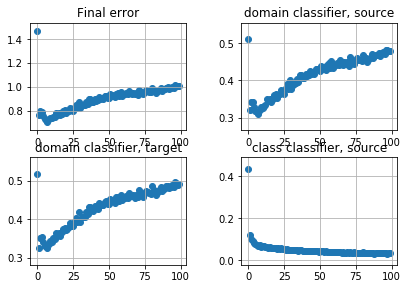

In [27]:
plt.figure(1)

plt.subplot(221)
plt.scatter(range(len(final_err)), final_err)
plt.title('Final error')
plt.grid(True)

plt.subplot(222)
plt.scatter(range(len(source_err)), source_err)
plt.title('domain classifier, source')
plt.grid(True)

plt.subplot(223)
plt.scatter(range(len(target_err)), target_err)
plt.title('domain classifier, target')
plt.grid(True)

plt.subplot(224)
plt.scatter(range(len(class_s_err)), class_s_err)
plt.title('class classifier, source')
plt.grid(True)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

plt.show()

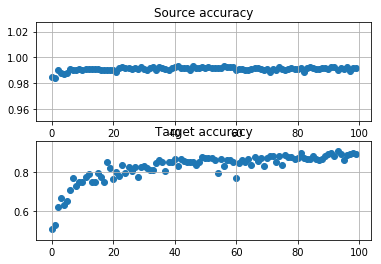

In [29]:
plt.figure(2)

plt.subplot(211)
plt.scatter(range(len(source_acc_list)), source_acc_list)
plt.title('Source accuracy')
plt.grid(True)

plt.subplot(212)
plt.scatter(range(len(target_acc_list)), target_acc_list)
plt.title('Target accuracy')
plt.grid(True)

plt.show()